<a href="https://colab.research.google.com/github/tanvikurundkar/Pneumonia-Detection/blob/main/Tanvi_PneumoniaDetection_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

Today, we'll use neural networks for pneumonia detection! We'll practice creating toy neural networks, apply neural networks (including Convolutional Neural Nets!) to our pneumonia data, and experiment with *transfer learning*: learning from an existing "expert network".

In this notebook we'll be:
1.   Building Neural Networks with Keras
2.   Implementing Transfer Learning
3.   Evalulating our ML models



In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
#%tensorflow_version 1.x

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
import keras.optimizers as optimizers
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121


class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):  
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of? 
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True 
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)
  
class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels      
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry. 
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 4)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    model.add(Dropout(0.5))

    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      model.add(Dropout(0.5))
    
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer= keras.optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(64, (3, 3), padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 64, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=1e-5, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])    
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16, 
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet', 
                                              include_top = False, 
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable
      
    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.5))

    expert_model.add(Dense(64, activation = 'relu'))
    expert_model.add(Dropout(0.5))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'], 
                  optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), 
                  metrics=['accuracy'])

    return expert_model

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
# gdown.download(image_data_url, './image_data.npy', True)
# gdown.download(metadata_url, './metadata.csv', True)
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

--2022-06-29 09:08:33--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40508 (40K) [text/csv]
Saving to: ‘metadata.csv’

metadata.csv        100%[===================>]  39.56K  --.-KB/s    in 0s      

2022-06-29 09:08:33 (107 MB/s) - ‘metadata.csv’ saved [40508/40508]

--2022-06-29 09:08:33--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 74.125.204.128, 2404:6800:4008:c07::80, ...
Connecting to storage.googlea

## Instructor-led Discussion: Steps for Building a NN in Keras

### What are neural networks?

Just as we went over last week, neural networks look something like this: 
![A 2 layer neural network](https://cdn-images-1.medium.com/max/1600/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)


Each orange and blue node is a neuron. The network itself is composed of a bunch of neurons that talk to each other and eventually give us a prediction. Let's get a bit more concrete with this...

To build neural networks in Python, we use the packages known as `tensorflow` and `keras`. Let's learn how to build and use these networks!

In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers

## Exercise (Coding): A 2-Layer Model


We're going to build this model: 

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as: 
* Input Layer: 3
* Layer 1 (Hidden): 4 neurons with the `'relu'` activation function
* Layer 2 (Output): 2 neurons with the `'softmax'` activation function

We're going to set up a **Sequential** model by adding on a sequence of layers.

Each layer will be **Dense**, meaning each neuron of the previous layer connects to each neuron of this layer.

We'll compile our model to make it ready to use! We'll use:
- `loss = 'categorical_crossentropy'` (how to measure the model's performance while it trains)
- `optimizer = 'adam'` (an algorithm for adjusting the weights)
- `metric = 'accuracy'` (how to measure the model's performance at the end)

Try it out below!

In [ ]:
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))
model_1.compile(loss='categorical_crossentropy',
                optimizer = 'adam', 
                metrics = ['accuracy'])
### END CODE

In [ ]:
#@title Double-click here if you want to read more detail!
"""
Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it. 


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'softmax'))
```
In this code, we `add` a `layer` of neurons to our network. 

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'softmax'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers. 

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it** 

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary. 

```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```
"""

In [ ]:
#@title Run this to test if your model is right!
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'softmax'))
model_1_answer.compile(loss='categorical_crossentropy',
optimizer = 'adam', 
metrics = ['accuracy'])

model_1_config = model_1.get_config()

del model_1_config["name"]
for layer in model_1_config["layers"]:
  del layer["config"]["name"]

model_1_answer_config = model_1_answer.get_config()

del model_1_answer_config["name"]
for layer in model_1_answer_config["layers"]:
  del layer["config"]["name"]

if model_1_answer_config == model_1_config:
  print('Good job! Your model worked')
else: 
  print('Please check your code again!')

# Old Code
# if model_to_string(model_1) == model_to_string(model_1_answer):
#   print('Good job! Your model worked')
# else: 
#   print('Please check your code again!')

Good job! Your model worked


This is a toy example, so we won't train our model with real data - but we can feed in some fake inputs to see what happens! **How many inputs do we need?**


In [ ]:
input_data = [[5,6,10]] #Fill in inputs here! How many?

Let's try it out! What do **predict** and **predict_classes** do? How do you interpret the outputs?

In [ ]:
print(model_1.predict(input_data))
print((model_1.predict(input_data) > 0.5).astype("int32"))

[[6.155955e-05 9.999385e-01]]
[[0 1]]


**How many outputs** are there? How would you interpret them?

# Milestone 2. Exploring Neural Networks

Now, let's apply neural networks to our medical imaging problem!


In our problem, we are given `images` of shape `(64,64,3)`, each assigned a label PNEUMONIA or HEALTHY. We want to identify the key things that we need to design our network. 

In your group, discuss: 

* What are our inputs?
* What is/are our outputs?

How could this look in a neural network diagram?

**Brainstorm and sketch out a neural network that would work for this problem, and share with the group!**

**Optional Exercise:** Following the setup from Notebook 1, create and test a neural network using Scikit-learn for this problem. [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) gives you a simple neural network!

In [ ]:
#YOUR CODE HERE
from sklearn.neural_network import MLPClassifier

(train_data, train_labels) = get_train_data(flatten = True)
(test_data, test_labels) = get_test_data(flatten = True)

#YOUR CODE HERE
mlp=MLPClassifier(hidden_layer_sizes=(64,))
mlp.fit(train_data,train_labels)
pred=mlp.predict(test_data)
accuracy=accuracy_score(test_labels,pred)
print(accuracy)

0.6775


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


## Activity 2a. Challenging pneumonia with our models

Now, let's try out 'Convolutional Neural Networks'! Convolutional neural networks are networks that process images much like our visual system does. We'll use a Keras wrapper that abstracts away the details - talk to your instructor if you're interested in exploring CNN with more details!

First, let's get our data. **Why do we not use flattened data for CNNs?**



In [ ]:
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

### Creating Models
Now, let's create a model! In fact, let's create two:


For a "vanilla" neural network:

```
dense = DenseClassifier(hidden_layer_sizes = (64,32))
```
* hidden_layer_sizes: the number of neurons in each hidden layer
* epochs: the number of times that our network trains on all of the training data


For a convolutional neural network:
```
cnn = CNNClassifier(num_hidden_layers = 1)
```
* num_hidden_layers: the number of hidden layers

**Create your models below!** Use any hidden layer sizes you like.

In [ ]:
#YOUR CODE HERE
dense = DenseClassifier(hidden_layer_sizes = (64,32))
cnn = CNNClassifier(num_hidden_layers = 1)

### Fitting and Scoring
Now, let's fit  our models!

There are default parameters to `.fit` you can call:

```
model_history = model.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
```

The `shuffle` parameter is important for shuffling the training data before each epoch. The `monitor` callback is used to get a view on internal states and statistics of the model during training. Please don't change these parameters!

**Fit your models below!**

In [ ]:
#YOUR CODE HERE
model_history_cnn = cnn.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
model_history_dense = dense.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

Epoch 1/50
63/63 [==============================] - 10s 134ms/step - loss: 1.5985 - accuracy: 0.5565 - val_loss: 1.5762 - val_accuracy: 0.7575
Epoch 2/50
63/63 [==============================] - 10s 154ms/step - loss: 1.5595 - accuracy: 0.6495 - val_loss: 1.5454 - val_accuracy: 0.7700
Epoch 3/50
63/63 [==============================] - 8s 134ms/step - loss: 1.5224 - accuracy: 0.7125 - val_loss: 1.5081 - val_accuracy: 0.7800
Epoch 4/50
63/63 [==============================] - 8s 133ms/step - loss: 1.4827 - accuracy: 0.7385 - val_loss: 1.4785 - val_accuracy: 0.7950
Epoch 5/50
63/63 [==============================] - 8s 132ms/step - loss: 1.4539 - accuracy: 0.7590 - val_loss: 1.4598 - val_accuracy: 0.7275
Epoch 6/50
63/63 [==============================] - 8s 128ms/step - loss: 1.4200 - accuracy: 0.7835 - val_loss: 1.4351 - val_accuracy: 0.7375
Epoch 7/50
63/63 [==============================] - 8s 133ms/step - loss: 1.3883 - accuracy: 0.7990 - val_loss: 1.3871 - val_accuracy: 0.8300
Epoc

**Can you interpret the numbers displayed? Which do you care about most?**

*Hint*: "validation set" is similar to "test set".

###Scoring

Now, let's evaluate our models! To get the scores, you can use:
```
score = model.evaluate(test_data, test_labels, verbose=0)
```

Then `score[0]` will be test loss and `score[1]` will be test accuracy.



In [ ]:
#YOUR CODE HERE to score your models
score_dense = dense.evaluate(test_data, test_labels, verbose=1)
score_cnn = cnn.evaluate(test_data, test_labels, verbose=1)
print(score_dense)
print(score_cnn)

13/13 [==============================] - 0s 33ms/step - loss: 1.1418 - accuracy: 0.7725
[0.3697383403778076, 0.8324999809265137]
[1.1417815685272217, 0.7724999785423279]


**Which model did better? Any surprises?**

### Plotting

A great way to understand our model better is to plot the training and test accuracy over time with `plot_acc(model_history)`.

**What do you observe of the training and test accuracy over the training epochs?**

Discuss this with your group and your instructor! What problems are we experiencing? How can we fix them? 

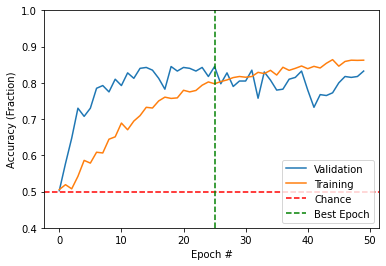

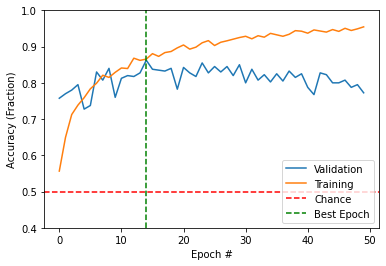

In [ ]:
#YOUR CODE HERE
plot_acc(model_history_dense)
plot_acc(model_history_cnn)

## Instructor-Led Discussion: Overfitting

**Questions:**
Was the best epoch necessarily the last epoch? 

You should check what the best epoch was at every step of the way!

**When does your model overfit? How could we fix it?**

**Experiment with different network structures** before you move on!


# Milestone 3. Expert models: Transfer learning


## Instructor-Led Discussion: Transfer Learning


So far, we've used models that were built from 'scratch'. Unfortunately, our training data is small relative to the amount of data available in the real world, so just training on our dataset is going to be inherently limited. 

Luckily, there are **expert models**, or state-of-the-art models that have been trained by the world's top researchers! While these expert models haven't trained on our training data, they have trained extensively on larger datasets. We can input our data and reasonably expect that they will pick up our task fairly quickly. 

In deep learning, the idea of using a model trained on another task as a starting point for your model is known as **transfer learning**. 

### VGG 16

For our transfer learning, we're going to use 'experts' built upon the famous 'ImageNet' classification problem. 

In ImageNet, participants were challenged to build machine learning models that could distinguish 14 million images' categories, where there were > 20,000 categories available. 

Below, we see examples of 4 different categories. 

![](http://cs231n.github.io/assets/trainset.jpg)



One of the experts we can use is VGG16. VGG16 is a specific convolutional neural network that was allowed to study the 14 million images 74 times. *(Read more about VGG16 [here!](https://neurohive.io/en/popular-networks/vgg16/))*

After training, VGG16 was able to guess something close to the real label (top-5 accuracy) better than a human can.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

We're going to take an expert model like VGG16 and let it train on OUR x-rays. Hopefully, its experience with those 14 million images will help it differentiate between healthy and pneumonia-affected x-rays. 

### Exercise (Coding) | Within a student group

Let's tap an expert model to help us out with our pneumonia prediction!

We provide a wrapper that lets you 'call' up and employ expert models. You can call it like...

```
transfer = TransferClassifier(name = 'VGG16')
```

The experts we have on hand are:
* `VGG16`
* `VGG19`
* `ResNet50`
* `DenseNet121`

There are default parameters to model.fit you can call:

`model.fit(train_data, train_labels, epochs = N, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])`

The `shuffle` parameter is important for shuffling the training data before each epoch. The `[monitor]` callback is used to get a view on internal states and statistics of the model during training. Do not change these parameters!

**Please experiment with using these experts! Remember to fit and score your model, and to take a look at the training history.**

How many epochs do you need now?


In [ ]:
### YOUR CODE HERE
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()
transfer = TransferClassifier(name = 'VGG16')
transfer.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
plot_acc(transfer.history)
### END CODE

# Milestone 4
## Instructor-led Discussion: Model Evaluation

## Activity 4a. How did we do on pneumonia prediction? 



### Exercise (Coding) 

Set your best model to the one you have trained (e.g., the transfer learning model).

In [ ]:
best_model = transfer ## Change this if another model did better!

As we learned last week, total accuracy does not reflect all that we want to know about a model's performance. It's just one metric out of many possible metrics for evaluating models. 

In the case of pneumonia prediction, we may be more interested in other quantities, such as 'how accurate were we on the pneumonia category?' or 'how accurate were we on the normal category?' or 'how much of pneumonia were confused for normal?' or vice versa. 



Our metrics for classification can be described in terms of a 'confusion matrix', shown below. 

![Confusion Matrix](https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

In a confusion matrix, we think in terms of 'actual' and 'predicted values'. If we take Pneumonia = 1/Positive and Normal = 0/Negative, then **what do TP, FP, TN, and FN mean?**




The `sklearn` package makes calculating confusion matrices very quick! Its `metrics` submodule actually comes with a `confusion_matrix` tool. Let's start by grabbing that.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

To use `confusion_matrix`, we need:
* `labels`: the labels of the data (1 - PNEUMONIA or 0 - NORMAL)
* `predictions`: what our model thinks the labels are

To get `predictions`, you'll want to use ```best_model.predict_classes(test_data)```. 

Please get the `predictions`, and use `accuracy_score` to print the overall test accuracy:

In [ ]:
#YOUR CODE HERE
predictions = (best_model.predict(test_data) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(test_labels, predictions)*)

Now let's get our confusion matrix, and split it out into true positive, true negative, false positive, and false negative!

In [ ]:
confusion = confusion_matrix(test_labels, predictions)
print(confusion)

**How do you interpret each number?**

In [ ]:
tp  = confusion[1][1]
tn  = confusion[0][0] 
fp = confusion[0][1]
fn = confusion[1][0]

print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

We can visualize the confusion matrix with seaborn to make it easier for our eyes...

In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');

**What do you notice about this confusion matrix?**

## Instructor-Led Discussion: Comparing False Positives and False Negatives

**Now that we have our confusion matrix, let's take a step back and discuss**

What did our model confuse more? 
* PNEUMONIA for NORMAL or...
* NORMAL for PNEUMONIA

Why do you think it might have confused one for the other? 

**Discuss with your instructor what you got and also...**

What is more problematic? False positives or False negatives? 

Which of these metrics do we want to keep low? 

**Optional challenge exercises:**
- Create a function to calculate [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). Which one do you care about more?
- Experiment with your models to find one that optimizes for what you care about, not just accuracy!**

# Fin!


To recap, we built neural network models to see if we can do better than our baseline models performed. It turns out that we can! And, also, by introducing convolutions to our networks (making the convolutional neural networks), we can improve by quite a lot. Finally, we employed pretrained 'expert' models to boost our performance even further.

In the next section, we'll test out our models on actual field data!

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)